<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Digits-Data" data-toc-modified-id="Digits-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Digits Data</a></span><ul class="toc-item"><li><span><a href="#Show-data-sampe" data-toc-modified-id="Show-data-sampe-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Show data sampe</a></span></li></ul></li><li><span><a href="#Pytorch-Logistic-Regression" data-toc-modified-id="Pytorch-Logistic-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pytorch Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression-class" data-toc-modified-id="Logistic-Regression-class-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression class</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Train-on-digits-data-set" data-toc-modified-id="Train-on-digits-data-set-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train on digits data set</a></span></li><li><span><a href="#Evaluate-digits" data-toc-modified-id="Evaluate-digits-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Evaluate digits</a></span></li><li><span><a href="#Misclassified-examples" data-toc-modified-id="Misclassified-examples-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Misclassified examples</a></span></li></ul></li><li><span><a href="#Logistic-Regression-with-sklearn" data-toc-modified-id="Logistic-Regression-with-sklearn-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic Regression with <code>sklearn</code></a></span></li></ul></div>

In [1]:
# imports
import pprint
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch import functional as F
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sns.set_style("white")

### Digits Data

In [2]:
d = datasets.load_digits()
print("d.images.shape: {}\nd.target.shape: {}".format(d.images.shape, d.target.shape))

d.images.shape: (1797, 8, 8)
d.target.shape: (1797,)


In [3]:
pprint.pprint(d.DESCR[:1000])

('.. _digits_dataset:\n'
 '\n'
 'Optical recognition of handwritten digits dataset\n'
 '--------------------------------------------------\n'
 '\n'
 '**Data Set Characteristics:**\n'
 '\n'
 '    :Number of Instances: 5620\n'
 '    :Number of Attributes: 64\n'
 '    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n'
 '    :Missing Attribute Values: None\n'
 "    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n"
 '    :Date: July; 1998\n'
 '\n'
 'This is a copy of the test set of the UCI ML hand-written digits datasets\n'
 'http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n'
 '\n'
 'The data set contains images of hand-written digits: 10 classes where\n'
 'each class refers to a digit.\n'
 '\n'
 'Preprocessing programs made available by NIST were used to extract\n'
 'normalized bitmaps of handwritten digits from a preprinted form. From a\n'
 'total of 43 people, 30 contributed to the training set and different 13\n'
 'to the test 

In [4]:
def plot_digit_subplots(digit_imgs, labels, predictions=None):
    n_plots = len(digit_imgs)
    n_col = min(10, n_plots)
    n_row = (n_plots // n_col) + 1
    fig, axs = plt.subplots(n_row, n_col, sharex=False, sharey=False)
    axs = np.array([axs]) if n_col==n_row==1 else axs
    axs = axs.reshape(n_row, -1)
    fig.set_size_inches((14, 2 * n_row))
    for i in range(n_col*n_row):
        a = axs[i//n_col, i % n_col]
        a.set_axis_off()
        a.axis("equal")
        if i >= n_plots:
            continue
        a.imshow(digit_imgs[i])
        sub_title = "Label: {}".format(labels[i])
        if predictions is not None:
            sub_title = sub_title + "\nPredict: {}".format(predictions[i])
        a.set_title(sub_title)

####  Show data sampe

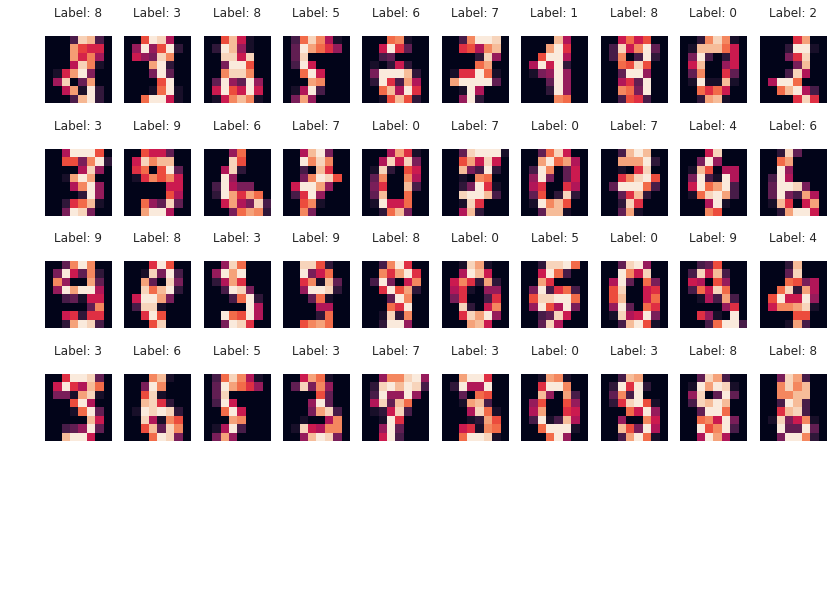

In [5]:
collage_size = 40
rand_ind = np.random.randint(0, len(d.images), size=collage_size)
plot_digit_subplots(d.images[rand_ind], d.target[rand_ind])

### Pytorch Logistic Regression

#### Logistic Regression class

In [6]:
class LogRegression(nn.Module):
    def __init__(self, features_num, classes_num, fit_intercept=True):
        super(LogRegression, self).__init__()
        self.linear = nn.Linear(features_num, classes_num, bias=fit_intercept)
    
    def forward(self, x):
        # just make weights * x + bias
        return self.linear(x)

#### Train

In [7]:
def train_torch_log_regression(X, y, model, lr, epochs, X_val=None, y_val=None, verbose=True):
    # set SGD optimizer with model weights and learning rate 
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    losses, losses_val = [], []
    accuracy, accuracy_val = [], []
    cross_entropy = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        # print(epoch)
        optimizer.zero_grad()  # backward() function accumulates gradients
        
        # forward pass
        logits = model(X)
        logits_val = model(X_val) if X_val is not None else None
        
        # backward pass 
        loss_var = cross_entropy(logits, y)
        loss_var_val = cross_entropy(logits_val, y_val) if X_val is not None else None
        loss_var.backward()  # grads - ompute derivatives
        optimizer.step()
        
        # losses save
        losses.append(loss_var.item())
        losses_val.append(loss_var_val.item()) if X_val is not None else None
        
        # accuracy save
        accuracy.append(accuracy_from_logits(logits, y))
        accuracy_val.append(accuracy_from_logits(logits_val, y_val))
        if verbose and epoch % 10 == 0:
            epoch_val_loss = loss_var_val.item() if X_val is not None else None
            print("Epoch {:4d} | Train Loss: {:10.3f} | Val Loss: {:10.3f}".
                  format(epoch, loss_var.item(), epoch_val_loss))
    return losses, losses_val, accuracy, accuracy_val

def accuracy_from_logits(predicted_logits, y_true):
    y_predicted = predicted_logits.argmax(dim=1)
    accuracy = accuracy_score(y_true, y_predicted)
    return accuracy

#### Train on digits data set

In [8]:
X = torch.tensor(data=d.data, dtype=torch.float32)
y = torch.tensor(data=d.target, dtype=torch.long)

print("X.shape: {} \ny.shape: {}".format(X.shape, y.shape))

X.shape: torch.Size([1797, 64]) 
y.shape: torch.Size([1797])


In [9]:
# split train / validation
tr_ind, val_ind = train_test_split(np.arange(len(y)), train_size=.8, test_size=.2)
print("train size: {}\nvalidation size: {}".format(len(tr_ind), len(val_ind)))
X_tr, X_val = X[tr_ind], X[val_ind]
y_tr, y_val = y[tr_ind], y[val_ind]

train size: 1437
validation size: 360


In [10]:
lr = .05
epochs = 150

model = LogRegression(features_num=X.shape[1], classes_num=10)
losses, losses_val, acc, acc_val = train_torch_log_regression(X_tr, y_tr, model, lr, epochs, X_val, y_val)

Epoch    0 | Train Loss:      6.469 | Val Loss:      6.825
Epoch   10 | Train Loss:      7.440 | Val Loss:      7.562
Epoch   20 | Train Loss:      2.500 | Val Loss:      2.077
Epoch   30 | Train Loss:      1.220 | Val Loss:      0.939
Epoch   40 | Train Loss:      0.646 | Val Loss:      0.611
Epoch   50 | Train Loss:      0.498 | Val Loss:      0.633
Epoch   60 | Train Loss:      0.376 | Val Loss:      0.697
Epoch   70 | Train Loss:      0.288 | Val Loss:      0.639
Epoch   80 | Train Loss:      0.225 | Val Loss:      0.643
Epoch   90 | Train Loss:      0.178 | Val Loss:      0.621
Epoch  100 | Train Loss:      0.140 | Val Loss:      0.630
Epoch  110 | Train Loss:      0.105 | Val Loss:      0.634
Epoch  120 | Train Loss:      0.078 | Val Loss:      0.624
Epoch  130 | Train Loss:      0.059 | Val Loss:      0.613
Epoch  140 | Train Loss:      0.044 | Val Loss:      0.607


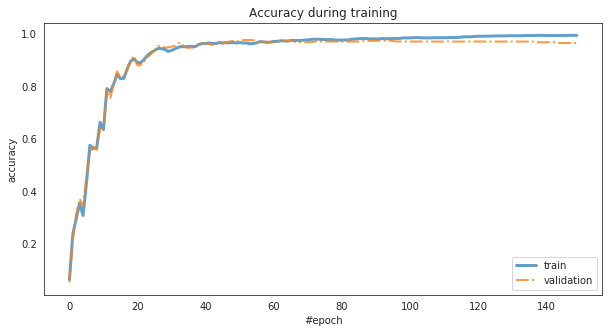

In [11]:
plt.plot(acc, lw=3, alpha=.7, label="train")
plt.plot(acc_val, lw=2, alpha=.8, ls="-.", label="validation")
plt.title("Accuracy during training")
plt.legend()
plt.xlabel("#epoch")
plt.ylabel("accuracy")
fig = plt.gcf()
fig.set_size_inches((10, 5))
plt.show()

#### Evaluate digits

In [12]:
logits = model(X_val)
predictions = logits.argmax(dim=1)

In [13]:
d.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
confusion_matrix(d.target[val_ind], predictions)

array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 40,  0,  0,  1,  0,  0,  0,  1,  0],
       [ 0,  0, 29,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 36,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  0,  0,  1,  0,  0],
       [ 0,  0,  1,  0,  0, 28,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0, 32,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0, 38,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  1,  0, 40]])

In [15]:
acc_torch = accuracy_score(d.target[val_ind], predictions)
acc_torch

0.9666666666666667

#### Misclassified examples

In [16]:
# let's see misclassified examples
predictions_np = predictions.numpy()
misclass_ind = np.argwhere(predictions_np != d.target[val_ind])
misclass_ind = misclass_ind.flatten()
misclass_ind

array([  0,  13,  27, 109, 161, 164, 174, 214, 250, 289, 316, 332])

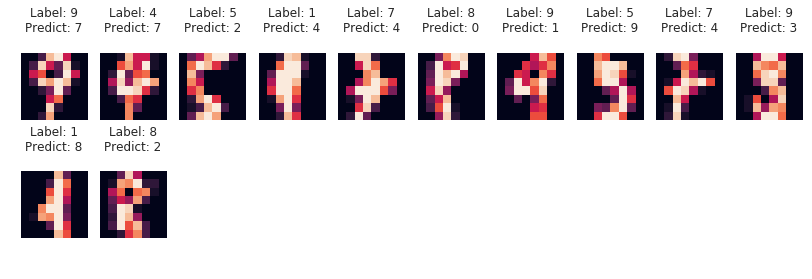

In [17]:
plot_digit_subplots(d.images[val_ind][misclass_ind], 
                    d.target[val_ind][misclass_ind], 
                    predictions_np[misclass_ind])

In [18]:
print("pytorch acc: {:2.2f}% [{:4d}/{:4d}]".format(acc_torch * 100, 
                                                   len(predictions_np) - len(misclass_ind), 
                                                   len(predictions_np)))

pytorch acc: 96.67% [ 348/ 360]


### Logistic Regression with `sklearn`

In [19]:
model_sk = LogisticRegression(C=.1, solver="newton-cg", multi_class="auto")
model_sk.fit(d.data[tr_ind], d.target[tr_ind])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
pred_sk = model_sk.predict(d.data[val_ind])
acc_sk = accuracy_score(d.target[val_ind], pred_sk)

misclass_ind_sk = np.argwhere(pred_sk != d.target[val_ind])
misclass_ind_sk = misclass_ind_sk.flatten()
misclass_ind_sk

array([ 26,  27, 161, 164, 167, 214, 289, 332])

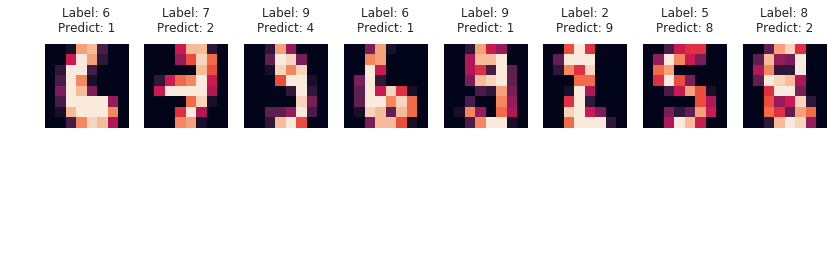

In [21]:
plot_digit_subplots(d.images[misclass_ind_sk], d.target[misclass_ind_sk], pred_sk[misclass_ind_sk])

In [22]:
print("sklearn acc: {:2.2f}% [{:4d}/{:4d}]".format(acc_sk * 100, 
                                                   len(pred_sk) - len(misclass_ind_sk), 
                                                   len(pred_sk)))

sklearn acc: 97.78% [ 352/ 360]
